In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial import KDTree
df = pd.read_csv("1-training_data.csv")
df_test = pd.read_csv("1-test_data.csv")
print(df.head())

        x.1       x.2    y
0  1.186215  0.222277  yes
1 -0.947284 -1.097843  yes
2 -0.345574 -1.121768  yes
3  0.252324 -0.421623  yes
4 -1.334506  0.318044  yes


In [34]:
features = df[['x.1', 'x.2']].values
#using the K-D Tree we can more easily look for
#the nearest neighbors of any one node
tree = KDTree(features)
print(df_test.iloc[0])

x.1    1.094037
x.2    0.075606
y           yes
Name: 0, dtype: object


In [3]:
def get_neighbors(i, K, test):
    #get the K neighbors of element i
    #return the labels of those labels
    
    #identify the element coordinante
    coords = i.iloc[0:2].values 
    #Query the three for the nearest neighbors + 1 to that coordinante
    #we query an additional point since the query returns the element itself
    _, neighbors = tree.query(coords, k = K) 
    neighbors = np.atleast_1d(neighbors)
    #for all the neighbors, check what label they have in the original dataframe
    if test:
        #if we are testing the KNN, we check for the neighbors generated during the training, column y_hat
        nearest_labels = [df.iloc[n]['y_hat'] for n in neighbors]
    else:
        #otherwise, we use the training dat
        nearest_labels = [df.iloc[n]['y'] for n in neighbors]

    return nearest_labels
    
print(get_neighbors(df_test.iloc[0], 1, False))

['yes']


In [4]:
def predict(neighbors):
    #make a predicition given the labels of the elements neighbors
    #neighbors.count returns the number of times an element is in the list, max of that is the 
    #most likely label
    return max(neighbors, key=neighbors.count)

print(predict(get_neighbors(df_test.iloc[0], 3, False)))

yes


In [5]:
def KNN(K, test):
    #iterate over the training data set, appending predictions to the array
    pred = []
    if test:
        for i in range(len(df_test)):
            pred.append(predict(get_neighbors(df_test.iloc[i], K, test)))
    else:
        for i in range(len(df)):
            pred.append(predict(get_neighbors(df.iloc[i],K,test)))
    return pred

In [6]:
def error(pred, test):
    #take the array of predicted element labels
    #return the error rate compared to training data
    if test:
        #measure error against the test data
        return np.mean(pred != df_test['y'].values)
    else:
        #or against the training data
        return np.mean(pred != df['y'].values)


In [7]:
training_err = []
test_err = []
for i in tqdm(range(40)):
    K = i * 5 + 1
    #first we generate our training predictions
    training_pred = KNN(K, False)
    #append to the original dataframe, pandas knows to replace outdated columns
    df['y_hat'] = training_pred
    #we test for that iteration
    test_pred = KNN(K, True)
    #finally we append the error values to the total lists
    training_err.append(error(training_pred, False))
    test_err.append(error(test_pred, True))

100%|██████████████████████████████████████████████████████████████| 40/40 [25:40<00:00, 38.52s/it]


In [8]:
print(training_err)
print(test_err)
k_values = np.arange(1,197, 5)

[0.0, 0.0751, 0.1106, 0.1034, 0.1157, 0.1086, 0.1152, 0.1124, 0.1166, 0.1122, 0.116, 0.1128, 0.1168, 0.1138, 0.1172, 0.1148, 0.117, 0.1152, 0.1177, 0.1158, 0.118, 0.1165, 0.1188, 0.1167, 0.1186, 0.1171, 0.1185, 0.1184, 0.1192, 0.1177, 0.1182, 0.1171, 0.1186, 0.1172, 0.1185, 0.1178, 0.1183, 0.1175, 0.1181, 0.1178]
[0.1705, 0.1315, 0.1255, 0.124, 0.1265, 0.1245, 0.1255, 0.121, 0.1215, 0.123, 0.122, 0.1215, 0.1235, 0.122, 0.1195, 0.1205, 0.12, 0.122, 0.1195, 0.1195, 0.1185, 0.117, 0.115, 0.117, 0.117, 0.1175, 0.1185, 0.1185, 0.12, 0.1195, 0.12, 0.1195, 0.1205, 0.12, 0.1195, 0.1195, 0.1205, 0.1185, 0.119, 0.119]


In [9]:
print(min(zip(test_err, k_values), key= lambda x: x[0]))
training_dict = dict(zip(k_values, training_err))
print(training_dict.get(111))

(0.115, 111)
0.1188


/tmp/ipykernel_23433/2273763301.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"yes":0, "no":1})


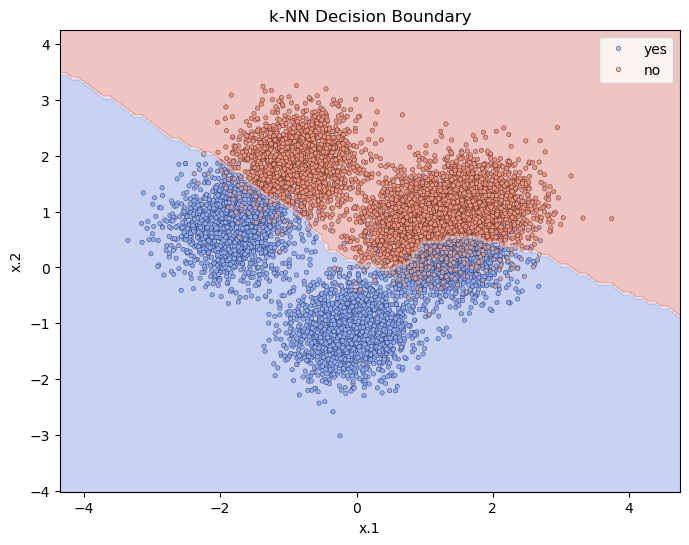

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

optim_pred = KNN(111, False)
df['y_hat'] = optim_pred

X = df[['x.1', 'x.2']].values  
y = df['y'].values 
df = df.replace({"yes":0, "no":1})
#pad the sides so the graph is a bit easier to look at
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#meshgrid discretizes the linear space that the data exists in, allowing us to use our kNN on it
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
#because get_neighbors excepts a dataframe row as the element argument, np.c_ stacks the coordinantes into [x,y] pairs 
# and pd.Dataframe() makes a frame out of it
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x.1','x.2'])
#apply the kNN over the grid
Z = np.array([predict(get_neighbors(point, 111, True)) for _, point in grid_points.iterrows()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
#plot the known points as a scatter plot with the color decided by the true label
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k', s=10)
#create a contour and fill in
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm") 
plt.xlabel("x.1")
plt.ylabel("x.2")
plt.title("k-NN Decision Boundary")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

k_values = np.arange(1,197, 5)
inv_k_values = 1 / k_values

data = pd.DataFrame({
    '1/K': np.tile(inv_k_values, 2),
    'Error Rate': np.concatenate([train_errors, test_errors]),
    'Dataset': ['Training'] * len(train_errors) + ['Testing'] * len(test_errors)
})
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='1/K', y='Error Rate', hue='Dataset', marker='o', markersize=3)
plt.xscale('log')
plt.axvline(x = (1/111))
plt.xlabel('1/K')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. 1/K in KNN')
plt.legend(title='Dataset')
plt.show()
plt.savefig("errors.png")
